In [2]:
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch 
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'pandas {pd.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'torch {torch.__version__}')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from torch.utils.data import TensorDataset
import optuna
from torch import nn

import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import optuna
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss
from sklearn import tree
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score

Package versions: 

numpy 1.23.5
pandas 1.5.3
scikit-learn 1.2.1
torch 2.0.0+cu117


C:\Users\ericx\anaconda3\envs\QBUS2820\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ericx\anaconda3\envs\QBUS2820\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\ericx\anaconda3\envs\QBUS2820\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value 

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


# Reading the data

In [3]:
bank = pd.read_csv('clean_store.csv')
predictors = list(bank.columns[:-1])
bank = bank[predictors]

index_train_v, index_test = train_test_split(bank.index, train_size=0.7, random_state=7)


train_v = bank.loc[index_train_v, :].copy()
test = bank.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()


X_train = train.loc[:, train.columns!='resp']
X_valid = valid.loc[:, test.columns!='resp']
X_test = test.loc[:, test.columns!='resp']

# predictors = list(X_train.columns)

y_train = train['resp']
y_valid = valid['resp']
y_test = test['resp']

In [4]:
feature_for_dt = X_train.columns
feature_for_rf = X_train.columns
feature_for_bag = X_train.columns

# Encoding the data

In [540]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.glmm import GLMMEncoder
from category_encoders.cat_boost import CatBoostEncoder

# Utilities

In [5]:
def plot_cm(labels, predictions):
    print(roc_auc_score(labels, predictions))
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total subscribed Transactions: ', np.sum(cm[1]))

In [6]:
def get_model_performance(algo, feature_list, algo_name):

  X_train = train[feature_list]
  X_test = test[feature_list]
  model = algo
  model.fit(X_train, y_train)

  # validation set predictions
  y_prob = np.zeros(len(y_test))
  y_prob = model.predict_proba(X_test)[:, 1]

  lfp = 1
  lfn = 19
  tau = lfp/(lfp+lfn)

  y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
  y_prob[y_prob > 1- 1e-5] =  1- 1e-5

  y_pred = (y_prob > tau).astype(int)
  # y_pred = model.predict(X_valid)
        
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

  columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'f1-score']

  results = pd.DataFrame(0.0, columns=columns, index=[algo_name])

  results.iloc[:,0] =  log_loss(y_test, y_prob)   # Cross entropy
  results.iloc[:,1] =   1 - accuracy_score(y_test, y_pred)   # Error rate
  results.iloc[:,2] =  roc_auc_score(y_test, y_prob)   # AUC
  results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
  results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
  results.iloc[:,5] =  precision_score(y_test, y_pred)   # Precision
  results.iloc[:,6] =  f1_score(y_test, y_pred)  #f1-score
  return results, model

# Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
rf_params = {'criterion': 'entropy',
 'min_samples_leaf': 40,
 'max_features': 43,
 'max_depth': 25}

In [9]:
random_forest = RandomForestClassifier(**rf_params, n_estimators = 1000,
                                        random_state = 42)
results, random_forest = get_model_performance(random_forest, feature_for_rf, "Random Forest")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
Random Forest,0.32648,0.45424,0.85223,0.96018,0.46124,0.26658,0.41731


# Decision tree

In [10]:
dt_params = {'criterion': 'gini', 'min_samples_leaf': 40, 'max_features': 30}

In [11]:
decision_tree = tree.DecisionTreeClassifier(random_state=42, **dt_params)
results, decision_tree = get_model_performance(decision_tree, feature_for_dt, "Decision Tree")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
Decision Tree,0.45423,0.38939,0.80261,0.86878,0.55795,0.28614,0.43049


# KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [16]:
results, decision_tree = get_model_performance(knn, feature_for_rf, "knn")
display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
knn,1.12548,0.32899,0.64765,0.581,0.68937,0.27613,0.37434


0.644576766599518
(True Negatives):  1768
(False Positives):  754
(False Negatives):  215
(True Positives):  307
Total subscribed Transactions:  522


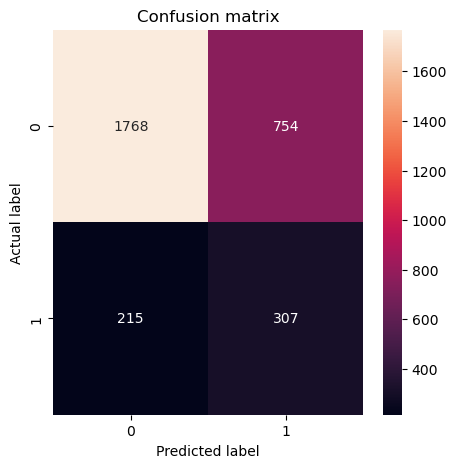

In [17]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = knn.predict_proba(valid[feature_for_rf])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_valid, y_pred)

# Bagging

In [57]:
from sklearn.ensemble import BaggingClassifier

In [58]:
bag_params = {'n_estimators': 200, 'max_samples': 1696, 'max_features': 44}

In [60]:
tuned_bag = BaggingClassifier(**bag_params, random_state=42)

results, fitted_model = get_model_performance(tuned_bag, feature_for_bag, "Bagging")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
Bagging,0.342,0.48705,0.83872,0.9448,0.42488,0.25096,0.39658


# XGBoost

In [18]:
import xgboost as xgb



In [26]:
xgb_params = {'objective': 'binary:logistic',
 'learning_rate': 0.01,
 'n_estimators': 1000,
 'max_depth': 3,
 'reg_alpha': 0.7188294522825762,
 'reg_lambda': 0.04453764012065286,
 'subsample': 0.6066128691026624,
 'colsample_bytree': 0.9052269579587887,
 'min_child_weight': 24,
 'verbosity': 0,
 'random_state': 7}

best_xgbst = xgb.XGBClassifier(**xgb_params).fit(X_train, y_train)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

columns=['Sensitivity', 'F1-score','Error Rate', 
         'Specificity', 'Precision', 'AUC', 'Cross-entropy']

rows=['XGBoost - Valid']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [best_xgbst]

# y_prob1 = np.zeros((len(y_valid), len(rows)))
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    
    y_prob[:, 0] = method.predict_proba(X_valid)[:, 1]
    y_pred = method.predict(X_valid)
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

    results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
    results.iloc[i,1] =  f1_score(y_valid, y_pred)  #f1-score
    results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)    # error rate
    results.iloc[i,3] =  tn/(tn+fp)  #specificity
    results.iloc[i,4] =  precision_score(y_valid, y_pred)  # precision
    results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,0])  # AUC
    results.iloc[i,6] =  log_loss(y_valid, y_prob[:,0])   #Corss-entropy


results.sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(3)

,Sensitivity,F1-score,Error Rate,Specificity,Precision,AUC,Cross-entropy
XGBoost - Valid,0.285,0.402,0.146,0.972,0.677,0.863,0.323


# Gradient Boost

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, n_estimators= 1901, subsample = 0.596)
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=1901,
                           subsample=0.596)

# Histogram Boost

In [29]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(learning_rate = 0.01, max_depth = 8, max_iter = 1901)

hgb.fit(X_train, y_train)

HistGradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_iter=1901)

# CatBoost

In [31]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(loss_function='Logloss', 
                       iterations = 2000, learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0
                      )
        
cb.fit(X_train, y_train)

# LightGBM

In [36]:
import lightgbm as lgb

lgbm_params = {'objective': 'binary',
 'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 6,
 'lambda_l1': 0.11405609272878144,
 'lambda_l2': 0.026615744329697977,
 'bagging_fraction': 0.7334404241713197,
 'bagging_freq': 4,
 'feature_fraction': 0.8680380019873142,
 'min_data_in_leaf': 102,
 'feature_pre_filter': False,
 'verbosity': -1}

In [37]:
import lightgbm as lgb


lgbm_train_data_2nd = lgb.Dataset(X_train, y_train)
lgbm_valid_data_2nd = lgb.Dataset(X_valid, y_valid, reference = lgbm_train_data_2nd)
lgbm_test_data_2nd = lgb.Dataset(X_test, y_test, reference = lgbm_train_data_2nd)

In [38]:
lgbm = lgb.train(lgbm_params, lgbm_train_data_2nd, num_boost_round=1000)

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score


columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score']
rows=['Best - LightBoost - Valid 1', 'Best - LightBoost - Valid 2']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[lgbm]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    

    y_prob = method.predict(X_valid)
    y_pred = [1 if x >= 1/20 else 0 for x in y_prob]

      
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_valid, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_valid, y_prob)
    results.iloc[i,5] =  log_loss(y_valid, y_prob)
    results.iloc[i,6] =  f1_score(y_valid, y_pred)  #f1-score

results.sort_values(by=['F1-score'], ascending = [0]).round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy,F1-score
Best - LightBoost - Valid 1,0.447,0.969,0.466,0.273,0.862,0.323,0.426
Best - LightBoost - Valid 2,0.000,0.000,0.000,0.000,0.000,0.000,0.000


# LightGBM Classifier

In [43]:
lgbmc_params = {'objective': 'binary',
 'learning_rate': 0.01,
 'n_estimators': 1000,
 'num_leaves': 4,
 'reg_alpha': 0.21215772927733817,
 'reg_lambda': 4.0468516923374466e-05,
 'subsample': 0.6437621101709328,
 'colsample_bytree': 0.9789740252242091,
 'min_child_samples': 120,
 'random_state': 7,
 'verbose': -1,
 'metric': 'binary_logloss'}

In [44]:
best_lgbm_c = lgb.LGBMClassifier(**lgbmc_params)

best_lgbm_c = best_lgbm_c.fit(X_train, y_train)

In [46]:

columns=['Sensitivity', 'F1-score','Error Rate', 
         'Specificity', 'Precision', 'AUC', 'Cross-entropy']

rows=['LightGBM Classifier - Valid']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [best_lgbm_c]

# y_prob1 = np.zeros((len(y_valid), len(rows)))
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    y_prob[:, 0] = method.predict_proba(X_valid)[:, 1]
    y_pred = method.predict(X_valid)
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

    results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
    results.iloc[i,1] =  f1_score(y_valid, y_pred)  #f1-score
    results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)    # error rate
    results.iloc[i,3] =  tn/(tn+fp)  #specificity
    results.iloc[i,4] =  precision_score(y_valid, y_pred)  # precision
    results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,0])  # AUC
    results.iloc[i,6] =  log_loss(y_valid, y_prob[:,0])   #Corss-entropy


results.sort_values(by=['F1-score','AUC'], ascending = [0,0]).round(3)

,Sensitivity,F1-score,Error Rate,Specificity,Precision,AUC,Cross-entropy
LightGBM Classifier - Valid,0.278,0.397,0.145,0.975,0.694,0.863,0.324


# Logistic regression

In [47]:
from sklearn.linear_model import LogisticRegression

In [49]:
logistic_regression = LogisticRegression(random_state=42, max_iter=2000).fit(X_train, y_train)

In [50]:
results, logistic_regression = get_model_performance(logistic_regression, X_train.columns, "logistic regression")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
logistic regression,0.33461,0.457,0.84638,0.95566,0.45884,0.26479,0.41469


# Super learner

In [51]:
from sklearn.model_selection import KFold
from numpy import hstack
from numpy import vstack
from numpy import asarray

In [71]:
class SuperLearner:
    
    def __init__(self, num_folds, model_features):
        self.num_folds = num_folds
        self.models = {}
        self.tau = 1/20
        self.model_features = model_features
        
    def add_model(self, model, name):
        self.models[name] = model
        
    def add_meta_model(self, model):
        self.meta_model = model
    
    # X is just the full dataset with all the encodings
    def fit_base_models(self, X, y, lgbm_params, xgb_params):
        for model in self.models:
            features = self.model_features[model]
            print(f'training features: {model}, shape: {X[features].shape}, {features}')
            if model == 'lgbm':
                lgbm_X_train_2nd = train[features].copy()
                lgbm_train_data_2nd = lgb.Dataset(lgbm_X_train_2nd, y_train)

                self.models[model] = self.models[model].train(lgbm_params, lgbm_train_data_2nd, num_boost_round=1000)
            else:
                self.models[model].fit(X[features], y)
    
    def fit_meta_model(self, meta_x, meta_y):
        self.meta = self.meta_model.fit(meta_x, meta_y)
        
    def get_out_of_fold_predictions(self, X, y):
        meta_x, meta_y = list(), list()
        
        kfolds = KFold(n_splits=self.num_folds, shuffle=True)
        
        for train_ix, test_ix in kfolds.split(X):
            print(train_ix)
            folds_yhats = list()
            train_x, test_x = X.iloc[train_ix], X.iloc[test_ix]
            train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
            meta_y.extend(test_y)
            
            for model in self.models:

                features = self.model_features[model]
                y_hat = None

                if model == 'lgbm':
    
                    lgbm_X_train = train_x[features].copy()
                    lgbm_X_test = test_x[features].copy()
            
                    lgbm_train_data = lgb.Dataset(lgbm_X_train, train_y)
                    lgbm_test_data = lgb.Dataset(lgbm_X_test, test_y, reference = lgbm_train_data_2nd)
                    
                    booster = lgb.train(lgbm_params, lgbm_train_data, num_boost_round=1000)
                    
                    y_hat = booster.predict(test_x[features])
                    
                else:
                    self.models[model].fit(train_x[features], train_y)
                    y_hat = self.models[model].predict_proba(test_x[features])
                    y_hat = y_hat[:, 1]
                
                y_prob[y_prob < 1e-5] = 1e-5 
                y_prob[y_prob > 1- 1e-5] =  1- 1e-5

                y_pred = (y_prob > 1/20).astype(int)
                
                folds_yhats.append(y_hat.reshape(len(y_hat),1))
                
                
#                 print(len(y_hat))
            meta_x.append(hstack(folds_yhats))
            
        self.meta_x = vstack(meta_x)
        self.meta_y = asarray(meta_y)
        return self.meta_x, self.meta_y
        
    def evaluate_models(self, X_valid, y_valid):
        for model in self.models:
            features = self.model_features[model]
            y_prob = 0
            if "lgbm" == model:
                y_prob = self.models[model].predict(X_valid[features])
            else:
                y_prob = self.models[model].predict_proba(X_valid[features])[:, 1]
                
            print(model)
            y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
            y_prob[y_prob > 1- 1e-5] =  1- 1e-5
            print(roc_auc_score(y_valid, y_prob))
                
    def super_learner_predict(self, X):
        meta_x = list()
        
        for model in self.models:
            print(model)
            features = self.model_features[model]
            print(features)
            yhat = None
            if "lgbm" == model:
                yhat = self.models[model].predict(X[features])
            else:
                yhat = self.models[model].predict_proba(X[features])[:, 1]
            
            meta_x.append(yhat.reshape(len(yhat),1))
        meta_x = hstack(meta_x)
            
        return self.meta_model.predict_proba(meta_x)

In [72]:
model_features = {'rf': X_train.columns, 'rf_uo': X_train.columns, 'dt_uo': X_train.columns, 'dt': X_train.columns, 
                  'bag': X_train.columns, 'bag_uo': X_train.columns, 'gb': X_train.columns, 
                  'hb': X_train.columns, 'cb': X_train.columns, 'lgbm': X_train.columns, 'lr': X_train.columns, 
                 'xgb': X_train.columns, 'lgbmc': X_train.columns}

In [73]:

sp = SuperLearner(2, model_features)

In [76]:
#uo stands for unoptimised

models = {'rf': RandomForestClassifier(random_state=42, **rf_params, n_estimators = 1000),
          'rf_uo': RandomForestClassifier(random_state=42, n_estimators = 1000),
          'dt': tree.DecisionTreeClassifier(random_state=42, **dt_params),
          'dt_uo': tree.DecisionTreeClassifier(random_state=42),
          'bag': BaggingClassifier(random_state=42, **bag_params),
          'bag_uo': BaggingClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'hb': HistGradientBoostingClassifier(random_state=42),
          'cb': CatBoostClassifier(random_state=42, loss_function='Logloss', 
                       iterations = 2000, learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0),
          'lgbm': lgb,
          'lgbmc': lgb.LGBMClassifier(**lgbmc_params),
          'lr': LogisticRegression(random_state=42, max_iter=10000),
           'xgb': xgb.XGBClassifier(**xgb_params)
         }

for i in models:
    sp.add_model(models[i], i)

In [77]:
meta_X, meta_y = sp.get_out_of_fold_predictions(train, y_train)

[    0     1     4 ... 12160 12161 12172]
[    2     3     6 ... 12169 12170 12171]


In [78]:
print('Meta ', meta_X.shape, meta_y.shape)

Meta  (12173, 13) (12173,)


In [79]:
sp.fit_base_models(train, y_train, lgbm_params, xgb_params)


training features: rf, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axs

In [80]:
sp.evaluate_models(test, y_test)

rf
0.8522292876602042
rf_uo
0.8360378259831064
dt
0.8026130428319211
dt_uo
0.6387435713701103
bag
0.8387201869418012
bag_uo
0.7953932676230897
gb
0.8504519875928905
hb
0.8473462014501687
cb
0.8443547484587155
lgbm
0.8538668657683707
lgbmc
0.853064529329919
lr
0.8463759982227834
xgb
0.8536492235534644


In [81]:
sp.add_meta_model(LogisticRegression(random_state=42, max_iter=1000))
sp.fit_meta_model(meta_X, meta_y)

In [82]:
y_prob = sp.super_learner_predict(test)

rf
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
rf_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

In [84]:

y_prob = y_prob[:, -1]
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob > tau).astype(int)

plot_cm(y_test, y_pred)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [85]:
print(roc_auc_score(y_test, y_prob))

0.8542448583488255


In [571]:

print(y_prob)

[0.49850965 0.06441789 0.05633458 ... 0.06558261 0.05602643 0.05140344]


0.571657577823222
(True Negatives):  1887
(False Positives):  7893
(False Negatives):  67
(True Positives):  1283
Total subscribed Transactions:  1350


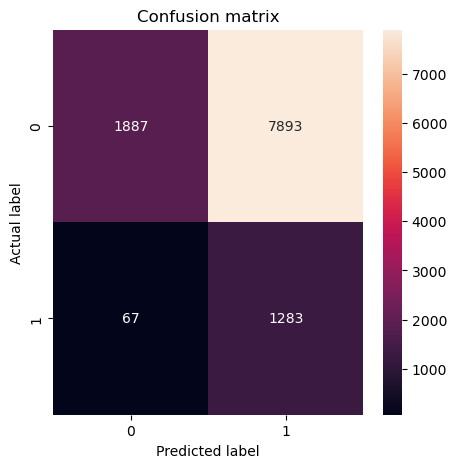

In [465]:
tau = 1/19
y_pred = (y_prob > tau).astype(int)

plot_cm(y_test, y_pred)

In [471]:
print(models.keys())

dict_keys(['rf', 'rf_uo', 'dt', 'dt_uo', 'bag', 'bag_uo', 'gb', 'hb', 'cb', 'lgbm', 'lr', 'xgb'])


# Optimising using optuna

In [91]:
from sklearn.base import clone

In [95]:
def create_model(trial):
    
    models = {'rf': RandomForestClassifier(random_state=42, **rf_params, n_estimators = 1000),
          'rf_uo': RandomForestClassifier(random_state=42, n_estimators = 1000),
          'dt': tree.DecisionTreeClassifier(random_state=42, **dt_params),
          'dt_uo': tree.DecisionTreeClassifier(random_state=42),
          'bag': BaggingClassifier(random_state=42, **bag_params),
          'bag_uo': BaggingClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'hb': HistGradientBoostingClassifier(random_state=42),
          'cb': CatBoostClassifier(random_state=42, loss_function='Logloss', 
                       iterations = 2000, learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0),
          'lgbm': lgb,
          'lgbmc': lgb.LGBMClassifier(**lgbmc_params),
          'lr': LogisticRegression(random_state=42, max_iter=10000),
           'xgb': xgb.XGBClassifier(**xgb_params)
         }

    models_chosen = {}
    
    model_names = ['rf', 'rf_uo', 'dt', 'dt_uo', 'bag', 'bag_uo', 'gb', 'hb', 'cb', 'lgbm', 'lr', 'xgb', 'lgbmc']
    
    meta_model = ['rf', 'rf_uo', 'dt', 'dt_uo','lgbmc', 'gb', 'hb', 'cb', 'lr', 'xgb']
    
    n_models = trial.suggest_int("n_models", 2, 13)
    
    for i in range(n_models):
        model_item = trial.suggest_categorical('model_{}'.format(i), model_names)
        if model_item not in models_chosen:
            if model_item == 'lgbm':
                models_chosen[model_item] = models[model_item]
            else:
                models_chosen[model_item] = clone(models[model_item])
                
    folds = trial.suggest_int("folds", 2, 6)
    model = SuperLearner(folds, model_features)
    
    for i in models_chosen:
        model.add_model(models_chosen[i], i)
        
    head = trial.suggest_categorical('head', meta_model)
    
    model.add_meta_model(models[head])
    
    return model





In [96]:
from sklearn.metrics import f1_score

def objective(trial):
    model = create_model(trial)
    
    meta_X, meta_y = model.get_out_of_fold_predictions(train, y_train)
    model.fit_base_models(train, y_train, lgbm_params, xgb_params)
    model.fit_meta_model(meta_X, meta_y)
    y_prob = model.super_learner_predict(test)
    
    tau = 1/20
    
    y_prob = y_prob[:, -1]
    y_prob[y_prob < 1e-5] = 1e-5
    y_prob[y_prob > 1- 1e-5] =  1- 1e-5

    y_pred = (y_prob > tau).astype(int)
    
    f1 = f1_score(y_test, y_pred)
    return f1

In [102]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200, timeout=50000)

[I 2023-05-22 22:12:24,153] A new study created in memory with name: no-name-192a0446-11b7-4449-acb9-559631e57474


[    2     3     5 ... 12169 12170 12172]
[    0     1     4 ... 12166 12167 12171]
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: xgb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
      

[I 2023-05-22 22:12:42,928] Trial 0 finished with value: 0.8538216001964292 and parameters: {'n_models': 6, 'model_0': 'lr', 'model_1': 'xgb', 'model_2': 'hb', 'model_3': 'lr', 'model_4': 'dt', 'model_5': 'dt_uo', 'folds': 2, 'head': 'lr'}. Best is trial 0 with value: 0.8538216001964292.


lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

[I 2023-05-22 22:14:41,170] Trial 1 finished with value: 0.8436931361691964 and parameters: {'n_models': 3, 'model_0': 'dt_uo', 'model_1': 'cb', 'model_2': 'bag', 'folds': 4, 'head': 'lr'}. Best is trial 0 with value: 0.8538216001964292.


[    0     2     3 ... 12169 12170 12171]
[    0     1     2 ... 12169 12171 12172]
[    1     2     3 ... 12168 12170 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     1     3 ... 12170 12171 12172]
training features: lgbmc, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_d

[I 2023-05-22 22:17:52,812] Trial 2 finished with value: 0.8514118348591674 and parameters: {'n_models': 5, 'model_0': 'lgbmc', 'model_1': 'lr', 'model_2': 'lr', 'model_3': 'rf_uo', 'model_4': 'lgbm', 'folds': 5, 'head': 'xgb'}. Best is trial 0 with value: 0.8538216001964292.


lgbm
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12170 12171 12172]
[    2     3     4 ... 12170 12171 12172]
[    0     1     2 ... 12167 12171 12172]
[    0     1     4 ... 12169 12170 12171]
[    0     1     2 ... 12169 12170 12172]
[    0     1     2 ... 12170 12171 12172]
training features: hb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_

[I 2023-05-22 22:25:10,987] Trial 3 finished with value: 0.8486024463452645 and parameters: {'n_models': 9, 'model_0': 'hb', 'model_1': 'lgbm', 'model_2': 'dt', 'model_3': 'dt_uo', 'model_4': 'dt', 'model_5': 'cb', 'model_6': 'cb', 'model_7': 'dt_uo', 'model_8': 'rf_uo', 'folds': 6, 'head': 'rf'}. Best is trial 0 with value: 0.8538216001964292.


[    1     3     5 ... 12170 12171 12172]
[    0     2     4 ... 12161 12167 12169]
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: bag_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
   

[I 2023-05-22 22:25:19,441] Trial 4 finished with value: 0.8474029086888183 and parameters: {'n_models': 2, 'model_0': 'lr', 'model_1': 'bag_uo', 'folds': 2, 'head': 'lr'}. Best is trial 0 with value: 0.8538216001964292.


lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
bag_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos',

dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-22 22:42:51,596] Trial 5 finished with value: 0.8418654760652026 and parameters: {'n_models': 11, 'model_0': 'bag', 'model_1': 'lgbmc', 'model_2': 'rf', 'model_3': 'dt', 'model_4': 'dt_uo', 'model_5': 'dt', 'model_6': 'xgb', 'model_7': 'rf_uo', 'model_8': 'lgbm', 'model_9': 'bag_uo', 'model_10': 'dt', 'folds': 6, 'head': 'rf_uo'}. Best is trial 0 with value: 0.8538216001964292.


[    1     2     3 ... 12167 12170 12172]
[    0     1     2 ... 12169 12171 12172]
[    0     1     5 ... 12170 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     2     3 ... 12169 12170 12171]
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres

[I 2023-05-22 22:57:44,267] Trial 6 finished with value: 0.8445363953571887 and parameters: {'n_models': 13, 'model_0': 'lr', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'rf_uo', 'model_4': 'rf_uo', 'model_5': 'lgbm', 'model_6': 'lgbmc', 'model_7': 'bag', 'model_8': 'rf', 'model_9': 'dt_uo', 'model_10': 'bag', 'model_11': 'rf', 'model_12': 'cb', 'folds': 5, 'head': 'hb'}. Best is trial 0 with value: 0.8538216001964292.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12170 12171 12172]
[    1     3     4 ... 12170 12171 12172]
[    0     1     2 ... 12168 12169 12172]
[    0     1     2 ... 12169 12170 12171]
[    0     2     5 ... 12170 12171 12172]
training features: dt_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_p

[I 2023-05-22 22:58:29,077] Trial 7 finished with value: 0.8150902221353657 and parameters: {'n_models': 4, 'model_0': 'dt_uo', 'model_1': 'lr', 'model_2': 'dt_uo', 'model_3': 'gb', 'folds': 5, 'head': 'dt'}. Best is trial 0 with value: 0.8538216001964292.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

rf
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lgbm
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', '

[I 2023-05-22 23:11:41,490] Trial 8 finished with value: 0.8538816480676946 and parameters: {'n_models': 12, 'model_0': 'dt_uo', 'model_1': 'xgb', 'model_2': 'rf_uo', 'model_3': 'rf', 'model_4': 'lgbm', 'model_5': 'dt', 'model_6': 'bag_uo', 'model_7': 'hb', 'model_8': 'hb', 'model_9': 'dt', 'model_10': 'rf_uo', 'model_11': 'dt_uo', 'folds': 5, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


[    0     1     4 ... 12170 12171 12172]
[    0     2     3 ... 12169 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     1     2 ... 12169 12170 12172]
[    0     1     2 ... 12169 12170 12171]
[    1     2     3 ... 12170 12171 12172]
training features: bag_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: bag, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20'

[I 2023-05-22 23:13:05,291] Trial 9 finished with value: 0.8523137221495635 and parameters: {'n_models': 12, 'model_0': 'bag_uo', 'model_1': 'bag', 'model_2': 'lgbm', 'model_3': 'bag_uo', 'model_4': 'bag_uo', 'model_5': 'bag', 'model_6': 'lgbmc', 'model_7': 'lgbm', 'model_8': 'dt_uo', 'model_9': 'dt_uo', 'model_10': 'bag', 'model_11': 'hb', 'folds': 6, 'head': 'xgb'}. Best is trial 8 with value: 0.8538816480676946.


[    1     2     4 ... 12170 12171 12172]
[    0     1     3 ... 12165 12167 12170]
[    0     2     3 ... 12169 12171 12172]
training features: rf, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: xgb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 

[I 2023-05-22 23:20:58,680] Trial 10 finished with value: 0.8533662719709232 and parameters: {'n_models': 9, 'model_0': 'rf', 'model_1': 'xgb', 'model_2': 'rf_uo', 'model_3': 'rf', 'model_4': 'lgbm', 'model_5': 'rf', 'model_6': 'bag_uo', 'model_7': 'hb', 'model_8': 'hb', 'folds': 3, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


[    2     6     7 ... 12166 12167 12170]
[    0     1     3 ... 12169 12171 12172]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: xgb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
    

[I 2023-05-22 23:25:02,989] Trial 11 finished with value: 0.85382285293366 and parameters: {'n_models': 6, 'model_0': 'lgbm', 'model_1': 'xgb', 'model_2': 'hb', 'model_3': 'lr', 'model_4': 'rf', 'model_5': 'dt_uo', 'folds': 2, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    2     4     5 ... 12168 12169 12170]
[    0     1     3 ... 12168 12171 12172]
[    0     1     2 ... 12170 12171 12172]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',


[I 2023-05-22 23:32:51,571] Trial 12 finished with value: 0.8536843837117435 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'gb', 'model_2': 'rf_uo', 'model_3': 'hb', 'model_4': 'rf', 'model_5': 'dt', 'model_6': 'dt', 'folds': 3, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12170 12171 12172]
[    1     2     3 ... 12167 12168 12169]
[    0     2     3 ... 12170 12171 12172]
[    0     1     3 ... 12170 12171 12172]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses

[I 2023-05-22 23:35:27,521] Trial 13 finished with value: 0.8536510609014029 and parameters: {'n_models': 9, 'model_0': 'lgbm', 'model_1': 'xgb', 'model_2': 'hb', 'model_3': 'cb', 'model_4': 'lgbmc', 'model_5': 'lgbmc', 'model_6': 'bag', 'model_7': 'cb', 'model_8': 'lr', 'folds': 4, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    1     4     5 ... 12169 12170 12171]
[    0     1     2 ... 12166 12167 12172]
[    0     2     3 ... 12170 12171 12172]
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
  

[I 2023-05-22 23:39:14,421] Trial 14 finished with value: 0.626064951919945 and parameters: {'n_models': 11, 'model_0': 'rf_uo', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'bag', 'model_4': 'cb', 'model_5': 'lr', 'model_6': 'rf_uo', 'model_7': 'hb', 'model_8': 'hb', 'model_9': 'dt', 'model_10': 'rf_uo', 'folds': 3, 'head': 'dt_uo'}. Best is trial 8 with value: 0.8538816480676946.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'da

[I 2023-05-22 23:47:36,989] Trial 15 finished with value: 0.8502923053538649 and parameters: {'n_models': 7, 'model_0': 'gb', 'model_1': 'dt_uo', 'model_2': 'bag_uo', 'model_3': 'lgbm', 'model_4': 'gb', 'model_5': 'dt_uo', 'model_6': 'rf', 'folds': 4, 'head': 'gb'}. Best is trial 8 with value: 0.8538816480676946.


[    0     2     3 ... 12169 12171 12172]
[    1     4     5 ... 12167 12168 12170]
training features: xgb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
      

[I 2023-05-22 23:51:48,921] Trial 16 finished with value: 0.8383664139478093 and parameters: {'n_models': 5, 'model_0': 'xgb', 'model_1': 'dt', 'model_2': 'lgbmc', 'model_3': 'lgbmc', 'model_4': 'rf', 'folds': 2, 'head': 'cb'}. Best is trial 8 with value: 0.8538816480676946.


[    0     1     5 ... 12169 12171 12172]
[    0     2     3 ... 12170 12171 12172]
[    1     2     3 ... 12168 12170 12171]
[    0     1     2 ... 12169 12170 12172]
[    0     1     2 ... 12170 12171 12172]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: hb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres

[I 2023-05-23 00:01:44,527] Trial 17 finished with value: 0.8517134939843558 and parameters: {'n_models': 8, 'model_0': 'dt', 'model_1': 'hb', 'model_2': 'hb', 'model_3': 'rf', 'model_4': 'hb', 'model_5': 'bag_uo', 'model_6': 'bag_uo', 'model_7': 'rf', 'folds': 5, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


bag_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     3 ... 12169 12171 12172]
[    1     2     4 ... 12170 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     2     3 ... 12168 12169 12170]
training features: cb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdress

[I 2023-05-23 00:03:56,994] Trial 18 finished with value: 0.8521914549958325 and parameters: {'n_models': 10, 'model_0': 'cb', 'model_1': 'xgb', 'model_2': 'gb', 'model_3': 'lr', 'model_4': 'lr', 'model_5': 'gb', 'model_6': 'lr', 'model_7': 'gb', 'model_8': 'cb', 'model_9': 'dt', 'folds': 4, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

hb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lgbmc
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 00:11:39,142] Trial 19 finished with value: 0.8515771961736395 and parameters: {'n_models': 13, 'model_0': 'lgbm', 'model_1': 'xgb', 'model_2': 'rf_uo', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'xgb', 'model_6': 'hb', 'model_7': 'lgbmc', 'model_8': 'xgb', 'model_9': 'rf', 'model_10': 'rf_uo', 'model_11': 'dt_uo', 'model_12': 'dt_uo', 'folds': 3, 'head': 'gb'}. Best is trial 8 with value: 0.8538816480676946.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    1     2     5 ... 12168 12170 12172]
[    0     1     2 ... 12169 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     3     4 ... 12170 12171 12172]
[    0     1     2 ... 12169 12170 12171]
training features: dt_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_p

[I 2023-05-23 00:22:33,512] Trial 20 finished with value: 0.8395982722248112 and parameters: {'n_models': 6, 'model_0': 'dt_uo', 'model_1': 'bag_uo', 'model_2': 'dt', 'model_3': 'rf', 'model_4': 'bag', 'model_5': 'hb', 'folds': 5, 'head': 'cb'}. Best is trial 8 with value: 0.8538816480676946.


hb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     2     4 ... 12168 12170 12171]
[    1     3     5 ... 12166 12169 12172]
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'am

[I 2023-05-23 00:22:51,242] Trial 21 finished with value: 0.8536757815827584 and parameters: {'n_models': 6, 'model_0': 'lr', 'model_1': 'xgb', 'model_2': 'hb', 'model_3': 'lr', 'model_4': 'dt', 'model_5': 'dt_uo', 'folds': 2, 'head': 'lr'}. Best is trial 8 with value: 0.8538816480676946.


lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

[I 2023-05-23 00:28:37,556] Trial 22 finished with value: 0.851325479506054 and parameters: {'n_models': 5, 'model_0': 'cb', 'model_1': 'xgb', 'model_2': 'hb', 'model_3': 'lr', 'model_4': 'rf', 'folds': 2, 'head': 'rf'}. Best is trial 8 with value: 0.8538816480676946.


[    0     2     3 ... 12168 12169 12170]
[    1     5     6 ... 12166 12171 12172]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: xgb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
      

[I 2023-05-23 00:29:10,618] Trial 23 finished with value: 0.847551232776951 and parameters: {'n_models': 8, 'model_0': 'dt', 'model_1': 'xgb', 'model_2': 'hb', 'model_3': 'lr', 'model_4': 'dt', 'model_5': 'dt_uo', 'model_6': 'gb', 'model_7': 'lr', 'folds': 2, 'head': 'hb'}. Best is trial 8 with value: 0.8538816480676946.


dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

[I 2023-05-23 00:30:21,901] Trial 24 finished with value: 0.835064783217998 and parameters: {'n_models': 6, 'model_0': 'xgb', 'model_1': 'dt_uo', 'model_2': 'gb', 'model_3': 'lr', 'model_4': 'lgbm', 'model_5': 'dt_uo', 'folds': 3, 'head': 'rf_uo'}. Best is trial 8 with value: 0.8538816480676946.


[    0     1     2 ... 12170 12171 12172]
[    4     5     7 ... 12165 12166 12169]
training features: lgbmc, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: cb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
    

[I 2023-05-23 00:31:22,431] Trial 25 finished with value: 0.8156719097895568 and parameters: {'n_models': 4, 'model_0': 'lgbmc', 'model_1': 'cb', 'model_2': 'lgbm', 'model_3': 'xgb', 'folds': 2, 'head': 'dt'}. Best is trial 8 with value: 0.8538816480676946.


lgbmc
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 00:33:36,519] Trial 26 finished with value: 0.8534588074943752 and parameters: {'n_models': 7, 'model_0': 'gb', 'model_1': 'dt', 'model_2': 'lr', 'model_3': 'lgbmc', 'model_4': 'lr', 'model_5': 'rf_uo', 'model_6': 'dt_uo', 'folds': 3, 'head': 'lr'}. Best is trial 8 with value: 0.8538816480676946.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12168 12170 12172]
[    4     7    10 ... 12167 12169 12171]
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd

[I 2023-05-23 00:35:48,293] Trial 27 finished with value: 0.6288780151297251 and parameters: {'n_models': 4, 'model_0': 'rf_uo', 'model_1': 'hb', 'model_2': 'bag_uo', 'model_3': 'cb', 'folds': 2, 'head': 'dt_uo'}. Best is trial 8 with value: 0.8538816480676946.


hb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
bag_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos',

[I 2023-05-23 00:42:03,177] Trial 28 finished with value: 0.8533339513503672 and parameters: {'n_models': 10, 'model_0': 'rf', 'model_1': 'lgbm', 'model_2': 'lgbmc', 'model_3': 'lgbm', 'model_4': 'gb', 'model_5': 'dt_uo', 'model_6': 'lgbm', 'model_7': 'bag_uo', 'model_8': 'lgbmc', 'model_9': 'gb', 'folds': 3, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


[    0     2     4 ... 12170 12171 12172]
[    1     3     4 ... 12168 12170 12171]
[    0     1     2 ... 12169 12170 12172]
[    0     1     2 ... 12169 12171 12172]
training features: dt_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: gb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',

[I 2023-05-23 00:42:29,566] Trial 29 finished with value: 0.8508569557817164 and parameters: {'n_models': 2, 'model_0': 'dt_uo', 'model_1': 'gb', 'folds': 4, 'head': 'lr'}. Best is trial 8 with value: 0.8538816480676946.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
gb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 00:50:34,890] Trial 30 finished with value: 0.8525739574303186 and parameters: {'n_models': 3, 'model_0': 'hb', 'model_1': 'rf', 'model_2': 'xgb', 'folds': 4, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    1     2     5 ... 12168 12169 12172]
[    0     3     4 ... 12169 12170 12171]
[    0     1     2 ... 12170 12171 12172]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
  

[I 2023-05-23 00:58:22,318] Trial 31 finished with value: 0.8526673281119246 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'gb', 'model_2': 'rf_uo', 'model_3': 'hb', 'model_4': 'rf', 'model_5': 'dt', 'model_6': 'dt', 'folds': 3, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    1     2     3 ... 12170 12171 12172]
[    0     6     9 ... 12165 12166 12169]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', '

[I 2023-05-23 01:02:51,258] Trial 32 finished with value: 0.8533430545742446 and parameters: {'n_models': 6, 'model_0': 'lgbm', 'model_1': 'gb', 'model_2': 'bag', 'model_3': 'hb', 'model_4': 'rf', 'model_5': 'dt', 'folds': 2, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12165 12168 12172]
[    3     5     6 ... 12169 12170 12171]
[    0     1     2 ... 12170 12171 12172]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
   

[I 2023-05-23 01:10:23,981] Trial 33 finished with value: 0.8534216429565267 and parameters: {'n_models': 8, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'rf_uo', 'model_3': 'hb', 'model_4': 'rf', 'model_5': 'dt', 'model_6': 'dt', 'model_7': 'dt', 'folds': 3, 'head': 'xgb'}. Best is trial 8 with value: 0.8538816480676946.


dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12165 12167 12168]
[    4     7     9 ... 12170 12171 12172]
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'am

[I 2023-05-23 01:12:04,532] Trial 34 finished with value: 0.852944350071573 and parameters: {'n_models': 5, 'model_0': 'lr', 'model_1': 'lgbmc', 'model_2': 'rf_uo', 'model_3': 'bag_uo', 'model_4': 'bag', 'folds': 2, 'head': 'lgbmc'}. Best is trial 8 with value: 0.8538816480676946.


[    0     1     4 ... 12164 12168 12171]
[    2     3     5 ... 12169 12170 12172]
training features: bag, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: cb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
      

[I 2023-05-23 01:13:37,922] Trial 35 finished with value: 0.8416534294099273 and parameters: {'n_models': 7, 'model_0': 'bag', 'model_1': 'bag', 'model_2': 'cb', 'model_3': 'dt', 'model_4': 'bag_uo', 'model_5': 'dt', 'model_6': 'bag_uo', 'folds': 2, 'head': 'rf'}. Best is trial 8 with value: 0.8538816480676946.


[    0     1     3 ... 12170 12171 12172]
[    0     2     3 ... 12170 12171 12172]
[    0     1     2 ... 12169 12170 12172]
[    0     1     2 ... 12170 12171 12172]
[    1     2     3 ... 12169 12170 12171]
[    0     1     2 ... 12169 12171 12172]
training features: bag_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: cb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20',

[I 2023-05-23 01:29:10,380] Trial 36 finished with value: 0.8521940439861095 and parameters: {'n_models': 6, 'model_0': 'bag_uo', 'model_1': 'cb', 'model_2': 'rf', 'model_3': 'gb', 'model_4': 'dt_uo', 'model_5': 'hb', 'folds': 6, 'head': 'lr'}. Best is trial 8 with value: 0.8538816480676946.


gb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

lgbm
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
gb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', '

[I 2023-05-23 01:31:41,511] Trial 37 finished with value: 0.8404336809261569 and parameters: {'n_models': 10, 'model_0': 'dt_uo', 'model_1': 'lr', 'model_2': 'dt_uo', 'model_3': 'bag', 'model_4': 'lgbm', 'model_5': 'gb', 'model_6': 'dt', 'model_7': 'xgb', 'model_8': 'gb', 'model_9': 'hb', 'folds': 5, 'head': 'rf_uo'}. Best is trial 8 with value: 0.8538816480676946.


[    1     2     3 ... 12169 12170 12172]
[    0     2     3 ... 12169 12170 12171]
[    0     1     4 ... 12168 12171 12172]
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: gb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', '

[I 2023-05-23 01:35:36,478] Trial 38 finished with value: 0.8544478017802232 and parameters: {'n_models': 12, 'model_0': 'lr', 'model_1': 'gb', 'model_2': 'bag', 'model_3': 'dt_uo', 'model_4': 'cb', 'model_5': 'rf_uo', 'model_6': 'bag', 'model_7': 'hb', 'model_8': 'dt', 'model_9': 'rf_uo', 'model_10': 'xgb', 'model_11': 'dt_uo', 'folds': 3, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


hb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'da

bag
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')


[I 2023-05-23 01:41:14,664] Trial 39 finished with value: 0.8109904307578726 and parameters: {'n_models': 12, 'model_0': 'lr', 'model_1': 'xgb', 'model_2': 'hb', 'model_3': 'dt_uo', 'model_4': 'cb', 'model_5': 'rf_uo', 'model_6': 'bag', 'model_7': 'hb', 'model_8': 'dt', 'model_9': 'rf_uo', 'model_10': 'xgb', 'model_11': 'dt_uo', 'folds': 5, 'head': 'dt'}. Best is trial 38 with value: 0.8544478017802232.


dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    5     6     7 ... 12162 12164 12167]
[    0     1     2 ... 12170 12171 12172]
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'am

dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 01:44:05,694] Trial 40 finished with value: 0.8436419409743623 and parameters: {'n_models': 12, 'model_0': 'lr', 'model_1': 'lgbm', 'model_2': 'bag', 'model_3': 'dt_uo', 'model_4': 'cb', 'model_5': 'rf_uo', 'model_6': 'bag', 'model_7': 'hb', 'model_8': 'bag_uo', 'model_9': 'bag', 'model_10': 'lgbmc', 'model_11': 'gb', 'folds': 2, 'head': 'hb'}. Best is trial 38 with value: 0.8544478017802232.


[    3     5     8 ... 12169 12170 12172]
[    0     1     2 ... 12168 12169 12171]
[    0     1     2 ... 12170 12171 12172]
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: gb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', '

dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lgbm
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', '

[I 2023-05-23 01:47:05,480] Trial 41 finished with value: 0.8536511444172183 and parameters: {'n_models': 13, 'model_0': 'lr', 'model_1': 'gb', 'model_2': 'bag', 'model_3': 'rf_uo', 'model_4': 'dt', 'model_5': 'bag', 'model_6': 'lgbm', 'model_7': 'hb', 'model_8': 'dt', 'model_9': 'lgbmc', 'model_10': 'lr', 'model_11': 'bag_uo', 'model_12': 'lr', 'folds': 3, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


[    2     3     4 ... 12167 12171 12172]
[    0     1     3 ... 12170 12171 12172]
[    0     1     2 ... 12168 12169 12170]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: gb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses',

rf
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')


[I 2023-05-23 01:55:42,683] Trial 42 finished with value: 0.8539249092600665 and parameters: {'n_models': 11, 'model_0': 'lgbm', 'model_1': 'gb', 'model_2': 'rf_uo', 'model_3': 'dt_uo', 'model_4': 'rf_uo', 'model_5': 'lgbm', 'model_6': 'xgb', 'model_7': 'lr', 'model_8': 'bag', 'model_9': 'rf_uo', 'model_10': 'rf', 'folds': 3, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


[    0     1     2 ... 12170 12171 12172]
[    0     2     3 ... 12170 12171 12172]
[    0     1     2 ... 12168 12169 12172]
[    1     3     5 ... 12169 12170 12171]
training features: lgbmc, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: gb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',

lgbm
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 01:59:40,381] Trial 43 finished with value: 0.8529373347430802 and parameters: {'n_models': 11, 'model_0': 'lgbmc', 'model_1': 'gb', 'model_2': 'bag', 'model_3': 'dt_uo', 'model_4': 'rf_uo', 'model_5': 'lgbm', 'model_6': 'xgb', 'model_7': 'lr', 'model_8': 'bag', 'model_9': 'rf_uo', 'model_10': 'dt_uo', 'folds': 4, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


[    0     1     2 ... 12170 12171 12172]
[    1     2     5 ... 12170 12171 12172]
[    0     1     2 ... 12168 12169 12171]
[    0     2     3 ... 12170 12171 12172]
[    0     1     2 ... 12169 12170 12172]
[    0     1     3 ... 12170 12171 12172]
training features: hb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: bag_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20',

cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

[I 2023-05-23 02:19:32,032] Trial 44 finished with value: 0.8532617101700549 and parameters: {'n_models': 12, 'model_0': 'hb', 'model_1': 'bag_uo', 'model_2': 'lr', 'model_3': 'dt_uo', 'model_4': 'rf_uo', 'model_5': 'cb', 'model_6': 'xgb', 'model_7': 'lr', 'model_8': 'bag', 'model_9': 'xgb', 'model_10': 'rf', 'model_11': 'lgbm', 'folds': 6, 'head': 'xgb'}. Best is trial 38 with value: 0.8544478017802232.


lgbm
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     2     3 ... 12169 12170 12171]
[    0     1     3 ... 12165 12167 12172]
[    1     2     5 ... 12170 12171 12172]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
 

[I 2023-05-23 02:27:17,848] Trial 45 finished with value: 0.8517251861985105 and parameters: {'n_models': 11, 'model_0': 'lgbm', 'model_1': 'xgb', 'model_2': 'dt', 'model_3': 'dt_uo', 'model_4': 'rf_uo', 'model_5': 'lgbm', 'model_6': 'rf', 'model_7': 'xgb', 'model_8': 'hb', 'model_9': 'lgbm', 'model_10': 'lgbm', 'folds': 3, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


hb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    2     3     5 ... 12169 12171 12172]
[    0     1     4 ... 12166 12168 12170]
training features: bag, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'a

rf
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')


[I 2023-05-23 02:32:59,724] Trial 46 finished with value: 0.620236216132249 and parameters: {'n_models': 13, 'model_0': 'bag', 'model_1': 'lgbmc', 'model_2': 'rf_uo', 'model_3': 'rf', 'model_4': 'lgbmc', 'model_5': 'lgbm', 'model_6': 'hb', 'model_7': 'gb', 'model_8': 'dt', 'model_9': 'rf_uo', 'model_10': 'hb', 'model_11': 'lr', 'model_12': 'lgbmc', 'folds': 2, 'head': 'dt_uo'}. Best is trial 38 with value: 0.8544478017802232.


lgbm
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
hb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', '

training features: bag_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'sm

[I 2023-05-23 02:40:50,981] Trial 47 finished with value: 0.8524693956294503 and parameters: {'n_models': 12, 'model_0': 'dt_uo', 'model_1': 'gb', 'model_2': 'rf', 'model_3': 'lr', 'model_4': 'lgbm', 'model_5': 'lgbmc', 'model_6': 'cb', 'model_7': 'lgbm', 'model_8': 'bag', 'model_9': 'cb', 'model_10': 'bag_uo', 'model_11': 'lgbmc', 'folds': 3, 'head': 'gb'}. Best is trial 38 with value: 0.8544478017802232.


bag_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12169 12170 12171]
[    0     1     2 ... 12169 12171 12172]
[    0     2     3 ... 12168 12170 12172]
[    1     3     4 ... 12170 12171 12172]
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdress

[I 2023-05-23 02:50:48,188] Trial 48 finished with value: 0.8538615207561857 and parameters: {'n_models': 11, 'model_0': 'lr', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'cb', 'model_8': 'gb', 'model_9': 'lr', 'model_10': 'rf', 'folds': 4, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'da

[I 2023-05-23 03:00:44,515] Trial 49 finished with value: 0.853720462543992 and parameters: {'n_models': 11, 'model_0': 'lr', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'cb', 'model_8': 'gb', 'model_9': 'lr', 'model_10': 'rf', 'folds': 4, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'da

[I 2023-05-23 03:10:42,782] Trial 50 finished with value: 0.8541563315845122 and parameters: {'n_models': 10, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'cb', 'model_8': 'gb', 'model_9': 'lr', 'folds': 4, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 03:20:40,272] Trial 51 finished with value: 0.8543707166826182 and parameters: {'n_models': 10, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'cb', 'model_8': 'gb', 'model_9': 'lr', 'folds': 4, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 03:30:36,077] Trial 52 finished with value: 0.8539071203913886 and parameters: {'n_models': 10, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'cb', 'model_8': 'gb', 'model_9': 'lr', 'folds': 4, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 03:40:28,275] Trial 53 finished with value: 0.8531883832841425 and parameters: {'n_models': 10, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'cb', 'model_8': 'gb', 'model_9': 'lr', 'folds': 4, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 03:52:44,257] Trial 54 finished with value: 0.8533755422264315 and parameters: {'n_models': 9, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'cb', 'model_8': 'gb', 'folds': 5, 'head': 'lgbmc'}. Best is trial 38 with value: 0.8544478017802232.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 04:02:40,785] Trial 55 finished with value: 0.8547365159540261 and parameters: {'n_models': 10, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'dt_uo', 'model_8': 'gb', 'model_9': 'lr', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 04:12:49,399] Trial 56 finished with value: 0.8356337764682499 and parameters: {'n_models': 10, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'dt_uo', 'model_8': 'gb', 'model_9': 'lr', 'folds': 4, 'head': 'cb'}. Best is trial 55 with value: 0.8547365159540261.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 04:22:25,941] Trial 57 finished with value: 0.8547169732532249 and parameters: {'n_models': 9, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'dt_uo', 'model_8': 'gb', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 04:33:53,637] Trial 58 finished with value: 0.8536121425314311 and parameters: {'n_models': 9, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'hb', 'model_5': 'rf', 'model_6': 'xgb', 'model_7': 'dt_uo', 'model_8': 'rf_uo', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


[    0     1     2 ... 12168 12169 12171]
[    0     2     4 ... 12170 12171 12172]
[    1     2     3 ... 12168 12170 12172]
[    0     1     3 ... 12170 12171 12172]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',


[I 2023-05-23 04:43:42,930] Trial 59 finished with value: 0.8528822143049228 and parameters: {'n_models': 9, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'bag_uo', 'model_6': 'dt_uo', 'model_7': 'dt_uo', 'model_8': 'gb', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

lgbm
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos'

[I 2023-05-23 04:56:19,296] Trial 60 finished with value: 0.8430683543542642 and parameters: {'n_models': 9, 'model_0': 'bag_uo', 'model_1': 'rf', 'model_2': 'lgbm', 'model_3': 'dt_uo', 'model_4': 'cb', 'model_5': 'lr', 'model_6': 'bag', 'model_7': 'bag', 'model_8': 'lgbm', 'folds': 5, 'head': 'rf_uo'}. Best is trial 55 with value: 0.8547365159540261.


[    0     3     4 ... 12170 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    1     2     3 ... 12166 12169 12170]
[    0     1     2 ... 12168 12171 12172]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',


[I 2023-05-23 05:08:22,391] Trial 61 finished with value: 0.8546975975840545 and parameters: {'n_models': 10, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'rf_uo', 'model_8': 'gb', 'model_9': 'lr', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


gb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'da

cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 05:20:27,828] Trial 62 finished with value: 0.8544632522060702 and parameters: {'n_models': 11, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'lgbmc', 'model_7': 'rf_uo', 'model_8': 'gb', 'model_9': 'lr', 'model_10': 'cb', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


gb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'da

cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 05:33:57,695] Trial 63 finished with value: 0.852774729450516 and parameters: {'n_models': 10, 'model_0': 'lgbm', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'lgbmc', 'model_7': 'rf_uo', 'model_8': 'gb', 'model_9': 'lr', 'folds': 4, 'head': 'rf'}. Best is trial 55 with value: 0.8547365159540261.


[    1     3     5 ... 12170 12171 12172]
[    0     1     2 ... 12169 12170 12171]
[    0     2     4 ... 12167 12169 12172]
[    0     1     2 ... 12170 12171 12172]
training features: rf, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: cb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
  

[I 2023-05-23 05:45:30,130] Trial 64 finished with value: 0.8528157357158724 and parameters: {'n_models': 8, 'model_0': 'rf', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'lgbmc', 'model_7': 'rf_uo', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


[    0     1     2 ... 12169 12171 12172]
[    0     1     2 ... 12169 12170 12171]
[    0     1     3 ... 12166 12170 12172]
[    2     5     6 ... 12170 12171 12172]
training features: cb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
  

[I 2023-05-23 05:57:09,831] Trial 65 finished with value: 0.8467570808884078 and parameters: {'n_models': 11, 'model_0': 'cb', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'bag_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'rf_uo', 'model_7': 'rf_uo', 'model_8': 'rf', 'model_9': 'lr', 'model_10': 'cb', 'folds': 4, 'head': 'hb'}. Best is trial 55 with value: 0.8547365159540261.


lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12168 12170 12172]
[    0     4     5 ... 12169 12171 12172]
[    1     2     3 ... 12169 12170 12171]
[    0     1     2 ... 12170 12171 12172]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses',

[I 2023-05-23 06:07:37,800] Trial 66 finished with value: 0.8537559567655327 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'bag', 'model_2': 'cb', 'model_3': 'gb', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt_uo', 'model_7': 'dt_uo', 'model_8': 'gb', 'model_9': 'lr', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 06:10:40,505] Trial 67 finished with value: 0.813270913612911 and parameters: {'n_models': 9, 'model_0': 'xgb', 'model_1': 'dt', 'model_2': 'dt_uo', 'model_3': 'rf_uo', 'model_4': 'xgb', 'model_5': 'xgb', 'model_6': 'gb', 'model_7': 'rf_uo', 'model_8': 'dt_uo', 'folds': 4, 'head': 'dt'}. Best is trial 55 with value: 0.8547365159540261.


gb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    1     3     4 ... 12168 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     2     3 ... 12169 12170 12171]
[    0     1     2 ... 12169 12170 12172]
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresse

[I 2023-05-23 06:23:15,364] Trial 68 finished with value: 0.8520303529879453 and parameters: {'n_models': 11, 'model_0': 'rf_uo', 'model_1': 'dt_uo', 'model_2': 'gb', 'model_3': 'cb', 'model_4': 'dt_uo', 'model_5': 'rf', 'model_6': 'lr', 'model_7': 'dt_uo', 'model_8': 'gb', 'model_9': 'bag_uo', 'model_10': 'xgb', 'folds': 4, 'head': 'gb'}. Best is trial 55 with value: 0.8547365159540261.


lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
bag_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos',

rf
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')


[I 2023-05-23 06:33:58,710] Trial 69 finished with value: 0.8543682947239719 and parameters: {'n_models': 12, 'model_0': 'gb', 'model_1': 'lr', 'model_2': 'lgbmc', 'model_3': 'lgbmc', 'model_4': 'bag_uo', 'model_5': 'rf_uo', 'model_6': 'lgbmc', 'model_7': 'rf', 'model_8': 'lr', 'model_9': 'lr', 'model_10': 'gb', 'model_11': 'rf_uo', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


[    0     2     3 ... 12170 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     1     2 ... 12169 12171 12172]
[    0     1     4 ... 12170 12171 12172]
[    1     2     3 ... 12168 12169 12170]
training features: gb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres

rf
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')


[I 2023-05-23 06:47:53,749] Trial 70 finished with value: 0.8418689837294488 and parameters: {'n_models': 12, 'model_0': 'gb', 'model_1': 'lr', 'model_2': 'lgbmc', 'model_3': 'lgbm', 'model_4': 'bag_uo', 'model_5': 'rf_uo', 'model_6': 'lgbmc', 'model_7': 'rf', 'model_8': 'lr', 'model_9': 'lr', 'model_10': 'gb', 'model_11': 'rf_uo', 'folds': 5, 'head': 'cb'}. Best is trial 55 with value: 0.8547365159540261.


[    0     1     3 ... 12170 12171 12172]
[    1     2     3 ... 12168 12169 12171]
[    0     1     2 ... 12169 12170 12172]
[    0     2     4 ... 12170 12171 12172]
training features: gb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
  

[I 2023-05-23 06:51:31,935] Trial 71 finished with value: 0.8525321995226236 and parameters: {'n_models': 12, 'model_0': 'gb', 'model_1': 'lr', 'model_2': 'lgbmc', 'model_3': 'lgbmc', 'model_4': 'bag_uo', 'model_5': 'rf_uo', 'model_6': 'lgbmc', 'model_7': 'rf_uo', 'model_8': 'lr', 'model_9': 'lr', 'model_10': 'gb', 'model_11': 'bag', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


[    0     1     2 ... 12170 12171 12172]
[    0     1     2 ... 12168 12170 12171]
[    1     2     3 ... 12170 12171 12172]
[    0     5     6 ... 12167 12169 12172]
training features: gb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: hb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
  

[I 2023-05-23 07:01:28,103] Trial 72 finished with value: 0.8537704050015953 and parameters: {'n_models': 10, 'model_0': 'gb', 'model_1': 'hb', 'model_2': 'xgb', 'model_3': 'lgbmc', 'model_4': 'gb', 'model_5': 'cb', 'model_6': 'dt_uo', 'model_7': 'rf', 'model_8': 'xgb', 'model_9': 'lr', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     4 ... 12170 12171 12172]
[    1     2     3 ... 12169 12170 12172]
[    0     1     2 ... 12169 12171 12172]
[    0     2     3 ... 12169 12170 12171]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses

[I 2023-05-23 07:05:48,612] Trial 73 finished with value: 0.8545978797004788 and parameters: {'n_models': 11, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'bag_uo', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'rf_uo', 'model_6': 'lgbmc', 'model_7': 'lgbmc', 'model_8': 'cb', 'model_9': 'lr', 'model_10': 'cb', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


[    1     2     3 ... 12170 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     3     4 ... 12167 12171 12172]
[    0     1     2 ... 12168 12169 12170]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts

[I 2023-05-23 07:10:41,134] Trial 74 finished with value: 0.8535637033585051 and parameters: {'n_models': 11, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'bag_uo', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'bag', 'model_6': 'lgbmc', 'model_7': 'lgbmc', 'model_8': 'cb', 'model_9': 'dt_uo', 'model_10': 'cb', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


lgbmc
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

bag_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos'

[I 2023-05-23 07:15:02,640] Trial 75 finished with value: 0.631527637888787 and parameters: {'n_models': 13, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'bag_uo', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'rf_uo', 'model_6': 'lgbmc', 'model_7': 'lgbmc', 'model_8': 'cb', 'model_9': 'lgbm', 'model_10': 'cb', 'model_11': 'dt', 'model_12': 'rf_uo', 'folds': 4, 'head': 'dt_uo'}. Best is trial 55 with value: 0.8547365159540261.


[    1     3     5 ... 12170 12171 12172]
[    0     1     2 ... 12167 12168 12172]
[    0     1     2 ... 12169 12170 12171]
[    0     2     3 ... 12170 12171 12172]
training features: lgbmc, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: lr, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',

[I 2023-05-23 07:25:18,413] Trial 76 finished with value: 0.8531534736733095 and parameters: {'n_models': 11, 'model_0': 'lgbmc', 'model_1': 'lr', 'model_2': 'bag_uo', 'model_3': 'bag', 'model_4': 'bag_uo', 'model_5': 'gb', 'model_6': 'lgbmc', 'model_7': 'bag_uo', 'model_8': 'lgbmc', 'model_9': 'rf', 'model_10': 'cb', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12170 12171 12172]
[    0     1     3 ... 12168 12169 12170]
[    1     2     3 ... 12167 12171 12172]
[    0     2     4 ... 12170 12171 12172]
training features: gb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses',

[I 2023-05-23 07:37:29,766] Trial 77 finished with value: 0.8546089037881104 and parameters: {'n_models': 12, 'model_0': 'gb', 'model_1': 'rf_uo', 'model_2': 'lgbmc', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'rf_uo', 'model_6': 'cb', 'model_7': 'rf', 'model_8': 'lr', 'model_9': 'xgb', 'model_10': 'xgb', 'model_11': 'rf_uo', 'folds': 4, 'head': 'lgbmc'}. Best is trial 55 with value: 0.8547365159540261.


[    0     1     2 ... 12168 12170 12171]
[    0     1     2 ... 12168 12169 12172]
[    0     1     4 ... 12170 12171 12172]
[    0     2     3 ... 12170 12171 12172]
[    1     2     3 ... 12170 12171 12172]
training features: lgbm, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit

[I 2023-05-23 07:43:29,797] Trial 78 finished with value: 0.8532183654618676 and parameters: {'n_models': 12, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'bag', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'rf_uo', 'model_6': 'cb', 'model_7': 'lgbmc', 'model_8': 'bag_uo', 'model_9': 'xgb', 'model_10': 'xgb', 'model_11': 'cb', 'folds': 5, 'head': 'xgb'}. Best is trial 55 with value: 0.8547365159540261.


[    0     1     2 ... 12169 12170 12171]
[    0     3     4 ... 12170 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    1     2     3 ... 12168 12169 12172]
training features: hb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',

[I 2023-05-23 07:47:49,759] Trial 79 finished with value: 0.8547872100539678 and parameters: {'n_models': 13, 'model_0': 'hb', 'model_1': 'rf_uo', 'model_2': 'dt', 'model_3': 'dt_uo', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'cb', 'model_7': 'dt', 'model_8': 'dt', 'model_9': 'xgb', 'model_10': 'dt', 'model_11': 'xgb', 'model_12': 'lgbm', 'folds': 4, 'head': 'lgbmc'}. Best is trial 79 with value: 0.8547872100539678.


dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 07:50:20,150] Trial 80 finished with value: 0.8488256841198016 and parameters: {'n_models': 13, 'model_0': 'hb', 'model_1': 'lgbm', 'model_2': 'dt', 'model_3': 'dt_uo', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'cb', 'model_7': 'dt', 'model_8': 'dt', 'model_9': 'xgb', 'model_10': 'dt', 'model_11': 'xgb', 'model_12': 'lgbm', 'folds': 3, 'head': 'rf'}. Best is trial 79 with value: 0.8547872100539678.


[    0     2     4 ... 12169 12170 12172]
[    0     1     2 ... 12170 12171 12172]
[    1     2     3 ... 12167 12168 12171]
[    0     1     3 ... 12170 12171 12172]
training features: hb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',

[I 2023-05-23 07:54:38,993] Trial 81 finished with value: 0.8550397618797072 and parameters: {'n_models': 13, 'model_0': 'hb', 'model_1': 'rf_uo', 'model_2': 'dt', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'cb', 'model_7': 'dt', 'model_8': 'dt', 'model_9': 'xgb', 'model_10': 'dt', 'model_11': 'xgb', 'model_12': 'lgbm', 'folds': 4, 'head': 'lgbmc'}. Best is trial 81 with value: 0.8550397618797072.


[    0     2     3 ... 12170 12171 12172]
[    0     1     3 ... 12167 12168 12172]
[    1     2     3 ... 12170 12171 12172]
[    0     1     2 ... 12169 12170 12171]
training features: hb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',

[I 2023-05-23 07:58:53,422] Trial 82 finished with value: 0.8528625880883063 and parameters: {'n_models': 13, 'model_0': 'hb', 'model_1': 'rf_uo', 'model_2': 'dt', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'cb', 'model_7': 'dt', 'model_8': 'dt', 'model_9': 'xgb', 'model_10': 'dt', 'model_11': 'xgb', 'model_12': 'lgbm', 'folds': 4, 'head': 'lgbmc'}. Best is trial 81 with value: 0.8550397618797072.


[    0     2     3 ... 12169 12170 12172]
[    1     2     3 ... 12167 12169 12171]
[    0     1     2 ... 12170 12171 12172]
[    0     1     4 ... 12170 12171 12172]
training features: hb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',

[I 2023-05-23 08:03:09,232] Trial 83 finished with value: 0.852693552077957 and parameters: {'n_models': 13, 'model_0': 'hb', 'model_1': 'rf_uo', 'model_2': 'dt', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'cb', 'model_7': 'dt', 'model_8': 'dt', 'model_9': 'xgb', 'model_10': 'dt', 'model_11': 'xgb', 'model_12': 'xgb', 'folds': 4, 'head': 'lgbmc'}. Best is trial 81 with value: 0.8550397618797072.


dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

[I 2023-05-23 08:07:25,493] Trial 84 finished with value: 0.8521507827937377 and parameters: {'n_models': 12, 'model_0': 'hb', 'model_1': 'rf_uo', 'model_2': 'dt', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'cb', 'model_7': 'dt', 'model_8': 'dt', 'model_9': 'xgb', 'model_10': 'xgb', 'model_11': 'xgb', 'folds': 4, 'head': 'lgbmc'}. Best is trial 81 with value: 0.8550397618797072.


[    0     1     2 ... 12169 12170 12172]
[    0     1     2 ... 12166 12167 12171]
[    1     2     4 ... 12170 12171 12172]
[    0     3     6 ... 12170 12171 12172]
training features: hb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',

[I 2023-05-23 08:12:31,928] Trial 85 finished with value: 0.8531046169213063 and parameters: {'n_models': 13, 'model_0': 'hb', 'model_1': 'rf_uo', 'model_2': 'dt', 'model_3': 'xgb', 'model_4': 'bag', 'model_5': 'lgbmc', 'model_6': 'bag', 'model_7': 'hb', 'model_8': 'cb', 'model_9': 'gb', 'model_10': 'dt', 'model_11': 'rf_uo', 'model_12': 'hb', 'folds': 4, 'head': 'lgbmc'}. Best is trial 81 with value: 0.8550397618797072.


lgbmc
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

[I 2023-05-23 08:17:55,800] Trial 86 finished with value: 0.8439250595885344 and parameters: {'n_models': 12, 'model_0': 'bag', 'model_1': 'rf_uo', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'cb', 'model_5': 'rf_uo', 'model_6': 'cb', 'model_7': 'lgbm', 'model_8': 'dt', 'model_9': 'hb', 'model_10': 'xgb', 'model_11': 'xgb', 'folds': 4, 'head': 'rf_uo'}. Best is trial 81 with value: 0.8550397618797072.


[    0     1     2 ... 12170 12171 12172]
[    0     1     3 ... 12168 12169 12170]
[    0     1     2 ... 12169 12171 12172]
[    1     2     3 ... 12170 12171 12172]
[    0     2     3 ... 12170 12171 12172]
training features: rf, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: cb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres

[I 2023-05-23 08:32:24,329] Trial 87 finished with value: 0.846543614464271 and parameters: {'n_models': 11, 'model_0': 'rf', 'model_1': 'cb', 'model_2': 'bag_uo', 'model_3': 'cb', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'lgbm', 'model_7': 'dt', 'model_8': 'rf_uo', 'model_9': 'lgbmc', 'model_10': 'cb', 'folds': 5, 'head': 'hb'}. Best is trial 81 with value: 0.8550397618797072.


lgbmc
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     2     3 ... 12169 12170 12172]
[    1     3     5 ... 12168 12169 12171]
[    0     1     2 ... 12170 12171 12172]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
  

[I 2023-05-23 08:39:06,397] Trial 88 finished with value: 0.8545065969142576 and parameters: {'n_models': 13, 'model_0': 'dt', 'model_1': 'bag_uo', 'model_2': 'rf', 'model_3': 'bag_uo', 'model_4': 'lgbmc', 'model_5': 'lr', 'model_6': 'rf', 'model_7': 'gb', 'model_8': 'dt_uo', 'model_9': 'bag', 'model_10': 'dt', 'model_11': 'rf', 'model_12': 'bag_uo', 'folds': 3, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


[    0     2     3 ... 12170 12171 12172]
[    0     1     2 ... 12168 12170 12172]
[    0     1     3 ... 12169 12170 12171]
[    1     2     5 ... 12169 12171 12172]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: bag_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts'

[I 2023-05-23 08:48:03,058] Trial 89 finished with value: 0.8545839325593088 and parameters: {'n_models': 13, 'model_0': 'dt', 'model_1': 'bag_uo', 'model_2': 'rf', 'model_3': 'bag_uo', 'model_4': 'lgbmc', 'model_5': 'lr', 'model_6': 'rf', 'model_7': 'gb', 'model_8': 'dt_uo', 'model_9': 'bag', 'model_10': 'dt', 'model_11': 'rf', 'model_12': 'bag_uo', 'folds': 4, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


[    0     2     3 ... 12170 12171 12172]
[    1     2     3 ... 12169 12170 12172]
[    0     1     3 ... 12170 12171 12172]
[    0     1     2 ... 12167 12169 12171]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: bag_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts'

[I 2023-05-23 08:56:56,592] Trial 90 finished with value: 0.8543602772056944 and parameters: {'n_models': 13, 'model_0': 'dt', 'model_1': 'bag_uo', 'model_2': 'rf', 'model_3': 'bag_uo', 'model_4': 'lgbmc', 'model_5': 'lr', 'model_6': 'rf', 'model_7': 'gb', 'model_8': 'dt_uo', 'model_9': 'bag', 'model_10': 'dt', 'model_11': 'rf', 'model_12': 'bag_uo', 'folds': 4, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


[    1     4     6 ... 12169 12170 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     1     2 ... 12169 12170 12171]
[    0     2     3 ... 12168 12171 12172]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: bag_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts'

[I 2023-05-23 09:06:35,092] Trial 91 finished with value: 0.8541650172293127 and parameters: {'n_models': 13, 'model_0': 'dt', 'model_1': 'bag_uo', 'model_2': 'rf', 'model_3': 'bag_uo', 'model_4': 'lgbmc', 'model_5': 'lr', 'model_6': 'rf', 'model_7': 'gb', 'model_8': 'lgbm', 'model_9': 'bag', 'model_10': 'dt', 'model_11': 'rf', 'model_12': 'bag_uo', 'folds': 4, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


[    1     2     3 ... 12170 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     1     2 ... 12167 12168 12171]
[    0     3     4 ... 12169 12170 12172]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: bag_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts'

[I 2023-05-23 09:16:10,720] Trial 92 finished with value: 0.8534484515332669 and parameters: {'n_models': 13, 'model_0': 'dt', 'model_1': 'bag_uo', 'model_2': 'rf', 'model_3': 'bag_uo', 'model_4': 'lgbmc', 'model_5': 'lr', 'model_6': 'rf', 'model_7': 'gb', 'model_8': 'dt_uo', 'model_9': 'bag', 'model_10': 'bag', 'model_11': 'rf', 'model_12': 'bag', 'folds': 4, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


[    0     1     2 ... 12167 12168 12170]
[    0     1     2 ... 12170 12171 12172]
[    1     3     4 ... 12169 12171 12172]
[    0     2     3 ... 12170 12171 12172]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: bag_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts'

[I 2023-05-23 09:25:00,367] Trial 93 finished with value: 0.8538413099288612 and parameters: {'n_models': 13, 'model_0': 'dt', 'model_1': 'bag_uo', 'model_2': 'rf', 'model_3': 'bag_uo', 'model_4': 'lgbmc', 'model_5': 'lr', 'model_6': 'rf', 'model_7': 'gb', 'model_8': 'dt_uo', 'model_9': 'dt', 'model_10': 'dt', 'model_11': 'rf', 'model_12': 'gb', 'folds': 4, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


lgbmc
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

dt
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
rf_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 

[I 2023-05-23 09:36:50,757] Trial 94 finished with value: 0.8544718543350555 and parameters: {'n_models': 12, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'rf', 'model_3': 'bag_uo', 'model_4': 'lgbmc', 'model_5': 'xgb', 'model_6': 'hb', 'model_7': 'bag', 'model_8': 'dt_uo', 'model_9': 'bag', 'model_10': 'lgbmc', 'model_11': 'rf', 'folds': 4, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     2     3 ... 12168 12169 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     1     3 ... 12168 12170 12171]
[    1     2     3 ... 12170 12171 12172]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresse

bag_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lgbmc
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promo

[I 2023-05-23 09:48:56,403] Trial 95 finished with value: 0.8539847900997013 and parameters: {'n_models': 12, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'rf', 'model_3': 'bag_uo', 'model_4': 'lgbmc', 'model_5': 'xgb', 'model_6': 'hb', 'model_7': 'bag', 'model_8': 'dt_uo', 'model_9': 'bag', 'model_10': 'lgbmc', 'model_11': 'rf', 'folds': 4, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    1     2     3 ... 12170 12171 12172]
[    0     2     4 ... 12168 12169 12172]
[    0     1     3 ... 12168 12170 12171]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
  

bag_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lgbmc
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promo

[I 2023-05-23 09:57:45,180] Trial 96 finished with value: 0.8543275390060616 and parameters: {'n_models': 13, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'rf', 'model_3': 'bag_uo', 'model_4': 'lgbmc', 'model_5': 'xgb', 'model_6': 'hb', 'model_7': 'bag', 'model_8': 'dt_uo', 'model_9': 'bag', 'model_10': 'lgbmc', 'model_11': 'rf', 'model_12': 'dt', 'folds': 3, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     2     3 ... 12167 12171 12172]
[    1     2     6 ... 12169 12170 12171]
[    0     1     3 ... 12170 12171 12172]
[    0     1     2 ... 12169 12170 12172]
training features: dt, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresse

[I 2023-05-23 10:10:17,241] Trial 97 finished with value: 0.8532249632112833 and parameters: {'n_models': 12, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'rf', 'model_3': 'bag_uo', 'model_4': 'hb', 'model_5': 'lr', 'model_6': 'hb', 'model_7': 'dt_uo', 'model_8': 'dt_uo', 'model_9': 'cb', 'model_10': 'lr', 'model_11': 'rf', 'folds': 4, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


bag_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
hb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos',

training features: dt_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
cb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonsp

[I 2023-05-23 10:21:08,675] Trial 98 finished with value: 0.8541341163776185 and parameters: {'n_models': 13, 'model_0': 'cb', 'model_1': 'bag_uo', 'model_2': 'lgbm', 'model_3': 'rf', 'model_4': 'lr', 'model_5': 'bag_uo', 'model_6': 'bag_uo', 'model_7': 'xgb', 'model_8': 'hb', 'model_9': 'bag', 'model_10': 'dt_uo', 'model_11': 'hb', 'model_12': 'bag_uo', 'folds': 4, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


dt_uo
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12169 12171 12172]
[    0     1     2 ... 12169 12170 12171]
[    0     1     2 ... 12170 12171 12172]
[    2     3     5 ... 12170 12171 12172]
[    0     1     3 ... 12168 12170 12172]
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_p

[I 2023-05-23 10:36:00,707] Trial 99 finished with value: 0.854650411148359 and parameters: {'n_models': 12, 'model_0': 'rf_uo', 'model_1': 'lgbmc', 'model_2': 'lgbmc', 'model_3': 'hb', 'model_4': 'lgbmc', 'model_5': 'hb', 'model_6': 'rf', 'model_7': 'bag', 'model_8': 'lr', 'model_9': 'xgb', 'model_10': 'rf_uo', 'model_11': 'lgbmc', 'folds': 5, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

[I 2023-05-23 10:53:36,637] Trial 100 finished with value: 0.8146651266350309 and parameters: {'n_models': 12, 'model_0': 'rf_uo', 'model_1': 'lgbmc', 'model_2': 'lgbmc', 'model_3': 'hb', 'model_4': 'dt', 'model_5': 'hb', 'model_6': 'rf', 'model_7': 'gb', 'model_8': 'lr', 'model_9': 'xgb', 'model_10': 'rf_uo', 'model_11': 'lgbmc', 'folds': 6, 'head': 'dt'}. Best is trial 81 with value: 0.8550397618797072.


gb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'da

bag
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

[I 2023-05-23 11:08:11,786] Trial 101 finished with value: 0.8548037461854152 and parameters: {'n_models': 13, 'model_0': 'hb', 'model_1': 'lgbmc', 'model_2': 'lgbmc', 'model_3': 'hb', 'model_4': 'lgbmc', 'model_5': 'hb', 'model_6': 'rf', 'model_7': 'bag', 'model_8': 'lr', 'model_9': 'xgb', 'model_10': 'rf_uo', 'model_11': 'lgbmc', 'model_12': 'rf', 'folds': 5, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


[    0     1     2 ... 12170 12171 12172]
[    0     1     3 ... 12167 12168 12170]
[    1     2     3 ... 12170 12171 12172]
[    0     1     2 ... 12169 12171 12172]
[    0     2     5 ... 12170 12171 12172]
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: lgbmc, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pkni

[I 2023-05-23 11:22:59,685] Trial 102 finished with value: 0.8547583135818431 and parameters: {'n_models': 13, 'model_0': 'rf_uo', 'model_1': 'lgbmc', 'model_2': 'lgbmc', 'model_3': 'hb', 'model_4': 'lgbmc', 'model_5': 'hb', 'model_6': 'rf', 'model_7': 'bag', 'model_8': 'lr', 'model_9': 'xgb', 'model_10': 'rf_uo', 'model_11': 'lgbmc', 'model_12': 'rf', 'folds': 5, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

bag
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')


[I 2023-05-23 11:37:40,198] Trial 103 finished with value: 0.8545035903449036 and parameters: {'n_models': 13, 'model_0': 'rf_uo', 'model_1': 'lgbmc', 'model_2': 'lgbmc', 'model_3': 'hb', 'model_4': 'lgbmc', 'model_5': 'hb', 'model_6': 'rf', 'model_7': 'bag', 'model_8': 'lr', 'model_9': 'xgb', 'model_10': 'rf_uo', 'model_11': 'lgbmc', 'model_12': 'rf', 'folds': 5, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


lr
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

bag
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')


[I 2023-05-23 11:51:30,616] Trial 104 finished with value: 0.8547658300052281 and parameters: {'n_models': 13, 'model_0': 'rf_uo', 'model_1': 'lgbmc', 'model_2': 'lgbmc', 'model_3': 'hb', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'rf', 'model_7': 'bag', 'model_8': 'lr', 'model_9': 'xgb', 'model_10': 'rf_uo', 'model_11': 'lgbmc', 'model_12': 'rf', 'folds': 5, 'head': 'lr'}. Best is trial 81 with value: 0.8550397618797072.


xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     1     2 ... 12170 12171 12172]
[    0     3     4 ... 12167 12168 12169]
[    1     2     4 ... 12170 12171 12172]
[    0     1     2 ... 12170 12171 12172]
[    0     1     2 ... 12170 12171 12172]
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnt

[I 2023-05-23 11:55:44,356] Trial 105 finished with value: 0.8517266059673719 and parameters: {'n_models': 12, 'model_0': 'rf_uo', 'model_1': 'lgbmc', 'model_2': 'lgbmc', 'model_3': 'hb', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'rf_uo', 'model_7': 'bag', 'model_8': 'lr', 'model_9': 'xgb', 'model_10': 'rf_uo', 'model_11': 'lgbmc', 'folds': 5, 'head': 'gb'}. Best is trial 81 with value: 0.8550397618797072.


xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
[    0     2     6 ... 12170 12171 12172]
[    1     3     4 ... 12169 12170 12171]
[    0     1     2 ... 12169 12171 12172]
[    0     1     2 ... 12168 12170 12172]
[    0     1     2 ... 12170 12171 12172]
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnt

xgb
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
rf
Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'd

[I 2023-05-23 12:09:12,687] Trial 106 finished with value: 0.8539862098685628 and parameters: {'n_models': 13, 'model_0': 'rf_uo', 'model_1': 'lgbmc', 'model_2': 'lgbmc', 'model_3': 'hb', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'lr', 'model_7': 'bag', 'model_8': 'lr', 'model_9': 'xgb', 'model_10': 'rf_uo', 'model_11': 'lgbmc', 'model_12': 'rf', 'folds': 5, 'head': 'xgb'}. Best is trial 81 with value: 0.8550397618797072.


In [103]:
params = study.best_params
params

{'n_models': 13,
 'model_0': 'hb',
 'model_1': 'rf_uo',
 'model_2': 'dt',
 'model_3': 'xgb',
 'model_4': 'lr',
 'model_5': 'hb',
 'model_6': 'cb',
 'model_7': 'dt',
 'model_8': 'dt',
 'model_9': 'xgb',
 'model_10': 'dt',
 'model_11': 'xgb',
 'model_12': 'lgbm',
 'folds': 4,
 'head': 'lgbmc'}

[    0     1     3 ... 12168 12169 12172]
[    0     1     2 ... 12169 12170 12171]
[    1     2     3 ... 12170 12171 12172]
[    0     2     4 ... 12170 12171 12172]
training features: hb, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',
       'pcas_pnts', 'pshirts', 'pdresses', 'psuits', 'pouterwear', 'pjewelry',
       'pfashion', 'plegwear', 'pcollspnd', 'amspend', 'psspend', 'ccspend',
       'axspend', 'tmonspend', 'omonspend', 'smonspend', 'prevpd', 'gmp',
       'promos', 'days', 'fredays', 'markdown', 'classes', 'coupons', 'styles',
       'stores', 'web', 'mailed', 'responded', 'responserate', 'hi',
       'ltfreday', 'clustype', 'percret'],
      dtype='object')
training features: rf_uo, shape: (12173, 46), Index(['zip_code', 'fre', 'mon', 'cc_card', 'avrg', 'pc_calc20', 'psweaters',
       'pknit_tops', 'pknit_dres', 'pblouses', 'pjackets', 'pcar_pnts',

(True Negatives):  2434
(False Positives):  2984
(False Negatives):  32
(True Positives):  1073
Total subscribed Transactions:  1105


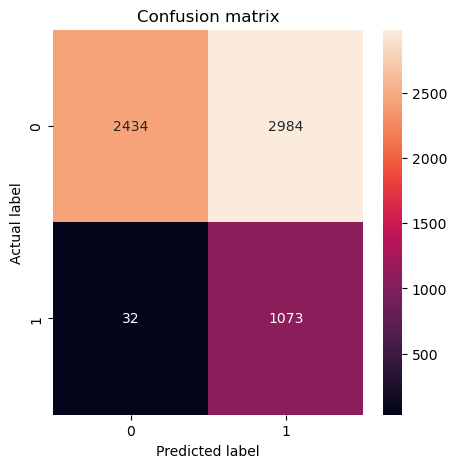

In [110]:
best_models =  {'model_0': 'hb',
 'model_1': 'rf_uo',
 'model_3': 'xgb',
 'model_4': 'lr',
 'model_6': 'cb',
 'model_10': 'dt',
 'model_12': 'lgbm'}

super_model = SuperLearner(4, model_features)

for i in best_models:
        super_model.add_model(models[best_models[i]], best_models[i])

super_model.add_meta_model(clone(models['lgbmc']))

meta_X, meta_y = super_model.get_out_of_fold_predictions(train, y_train)
super_model.fit_base_models(train, y_train, lgbm_params, xgb_params)
super_model.fit_meta_model(meta_X, meta_y)
y_prob = super_model.super_learner_predict(test)

tau = 1/20

y_prob = y_prob[:, -1]
y_prob[y_prob < 1e-5] = 1e-5
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob >tau).astype(int)
plot_cm(y_test, y_pred)

In [111]:
roc_auc_score(y_test, y_prob)

0.8531373551209392

In [112]:
f1_score(y_test, y_pred)

0.4157303370786516

0.7101419935893261
(True Negatives):  2434
(False Positives):  2984
(False Negatives):  32
(True Positives):  1073
Total subscribed Transactions:  1105


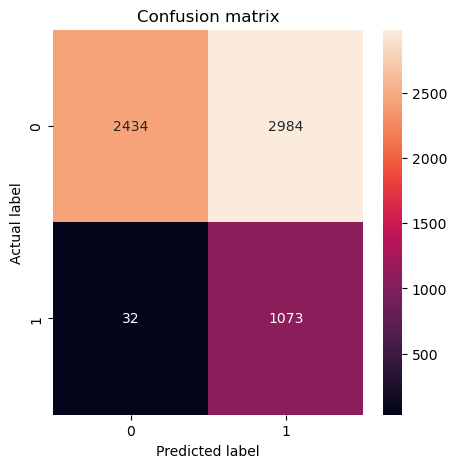

In [113]:
y_pred = (y_prob > 1/20).astype(int)
plot_cm(y_test, y_pred)

In [107]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision']

results = pd.DataFrame(0.0, columns=columns, index=["Model stack"])

results.iloc[:,0] =  log_loss(y_test, y_prob)   # Cross entropy
results.iloc[:,1] =   1 - accuracy_score(y_test, y_pred)   # Error rate
results.iloc[:,2] =  roc_auc_score(y_test, y_prob)   # AUC
results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
results.iloc[:,5] =  precision_score(y_test, y_pred)   # Precision

In [108]:
display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Model stack,0.32599,0.42833,0.85332,0.95385,0.49372,0.27759


In [684]:
best_models2 =  {'model_0': 'lgbm',
 'model_1': 'lr',
 'model_2': 'rf_uo',
 'model_3': 'dt'}

super_model = SuperLearner(6, model_features)

for i in best_models2:
        super_model.add_model(models[best_models2[i]], best_models2[i])

super_model.add_meta_model(clone(models['lr']))

meta_X, meta_y = super_model.get_out_of_fold_predictions(train, y_train)
super_model.fit_base_models(train, y_train, lgbm_params, xgb_params)
super_model.fit_meta_model(meta_X, meta_y)
y_prob = super_model.super_learner_predict(test)


[    1     2     5 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20773]
[    0     2     3 ... 20770 20772 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20771 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', '

0.8030847155949407
0.6323324244489889
(True Negatives):  3465
(False Positives):  6315
(False Negatives):  121
(True Positives):  1229
Total subscribed Transactions:  1350


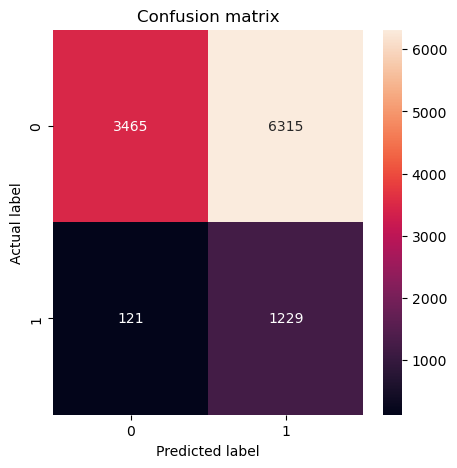

In [701]:

tau = 1/20

y_prob = y_prob
y_prob[y_prob < 1e-5] = 1e-5
y_prob[y_prob > 1- 1e-5] =  1- 1e-5
print(roc_auc_score(y_test, y_prob))
y_pred = (y_prob > tau).astype(int)
plot_cm(y_test, y_pred)

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Model stack,0.29058,0.60368,0.80482,0.92,0.32403,0.15816
